# Machine Learning 2024/2025 - Progress Task 2 (Application of K-Nearest Neighbours)

## Abstract

Given that there were a few alternatives to Random Forest that could potentially outperform it, the team decided to try the algorithm that was very close in performance to it: KNN. After making some runs with the random state, KNN did not give better results than Random Forest.

## Introduction

K-Nearest Neighbours (KNN) is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). KNN has been used in statistical estimation and pattern recognition. This algorithm classifies itself among the simplest of all machine learning algorithms.

### Strengths

- **Simple to implement**: KNN is very simple to understand and implement.
- **Flexible to feature/distance choices**: KNN can be used with any distance metric.
- **Naturally handles multi-class cases**: KNN naturally supports multi-class cases.

### Weaknesses

- **Computationally expensive**: KNN is computationally expensive because it stores all the training data.
- **High memory usage**: KNN requires high memory usage because it stores all the training data.
- **Sensitive to irrelevant features and the scale of the data**: KNN is sensitive to irrelevant features and the scale of the data.
- **Sensitivity to disbalance and outliers**.

## Methodology

The team used the K-Nearest Neighbours algorithm to classify the data. The team used the following hyperparameters:

- n_neighbors: 50
- weights: uniform

## Implementation

The team used the following code to implement the K-Nearest Neighbours algorithm:

In [22]:
!pip install pandas scipy scikit-learn

Defaulting to user installation because normal site-packages is not writeable


### Initial Configuration

In [23]:
# IMPORTS

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.multioutput import MultiOutputClassifier
import logging
import configparser

# GLOBAL VARIABLES

# Load configuration fileconfig["data"]["targets"]
CONFIG_FILE_PATH = "mlflow/test.conf"

config = configparser.ConfigParser()
config.read(CONFIG_FILE_PATH)
DATASET_PATH = config["data"]["dataset_path"]
TEST_DATASET_PATH = config["data"]["dataset_test_path"]
DATASET_INDEX_FEATURE = config["data"]["dataset_index"]
DATASET_TARGET_FEATURES = ["h1n1_vaccine", "seasonal_vaccine"]
CONFIG_SECTION_MLFLOW = "mlflow"
CONFIG_SECTION_NAMES = "names"
CONFIG_SECTION_DATA = "data"
CONFIG_PARAM_MLFLOW_ADDRESS = "mflow_address"
CONFIG_PARAM_MFLWOW_PORT = "mlflow_port"
CONFIG_PARAM_EXPERIMENT_NAME = "KNN"

OPTIMIZED_SUFFIX = config[CONFIG_SECTION_NAMES]["model_optimized"]
ROC_AUC_NAME = config[CONFIG_SECTION_NAMES]["parameter_roc_auc"]
ACCURACY_NAME = config[CONFIG_SECTION_NAMES]["parameter_accuracy"]
OUTPUT_FILE_PATH = config[CONFIG_SECTION_DATA]["output_path"]

# Load logging configuration
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S' 
)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
tuner_logger = logging.Logger("[Tuner]",level=logging.INFO)
tuner_logger.addHandler(ch)

run_logger = logging.Logger("[Run]",level=logging.INFO)
run_logger.addHandler(ch)

logger_main = logging.Logger("[Main]",level=logging.INFO)
logger_main.addHandler(ch)

### Dataset Setup

In [24]:
from sklearn.preprocessing import OneHotEncoder

# Dataset Class creation

class Dataset:
    '''
    ## Dataset
    
    This class represents a dataset. It handles dataset loading and splitting.
    
    ### Attributes
    
    - test: The test dataset.
    
    '''
    def __init__(self):
        '''
        Constructor for the Dataset class.
        '''
        data = pd.read_csv(DATASET_PATH)
        target = DATASET_TARGET_FEATURES
        data.set_index(DATASET_INDEX_FEATURE, inplace=True)
        self._y = data[target]
        self._X = data.drop(columns=target)
        test_data =  pd.read_csv(TEST_DATASET_PATH)
        test_data.set_index(DATASET_INDEX_FEATURE, inplace=True)
        self.test = test_data
    
    def with_correlation(self):
        '''
        ## with_correlation
        Method that returns a copy of the dataset features and targets.
        
        ### Returns
        (X, y): A tuple containing the dataset features and targets.
        '''
        
        return self._X.copy(), self._y.copy()
    
    def all_features(self):
        '''
        ## all_features
        Method that returns the dataset encoded with all the features without dropping the ones with random values.

        ### Returns
        X, y, test
        '''
        X = pd.read_csv(config["data"]["dataset_all_path"], index_col="respondent_id")
        target = ["h1n1_vaccine","seasonal_vaccine"]
        y = X[target]
        X = X.drop(columns=target)
        test = pd.read_csv(config["data"]["dataset_test_all_path"], index_col="respondent_id")
        return X, y, test    

    def all_onehot(self):
            X,y,test = self.all_features()
            encoder = OneHotEncoder()
            all_features = pd.concat([X, test])
            encoder.fit(all_features)
            encoder.fit(X)
            X = encoder.transform(X)
            test_transformed = encoder.transform(self.test)
            test_df = pd.DataFrame(test_transformed.toarray(), index=self.test.index)
            return X, y, test_df
    

### Method Definition for running the Experiment

In [25]:
from sklearn.neighbors import KNeighborsClassifier


    
# Set our tracking server uri for logging
experiment_name = CONFIG_PARAM_EXPERIMENT_NAME
logger_main.info("Starting Experiment: " + experiment_name)
    
# Create a new MLflow Experiment
logger_main.info("fetching data")
data = Dataset()
X, y = data.with_correlation()
output = data.test

models = {
    f"{config[CONFIG_SECTION_NAMES]['knn_model_name']}": MultiOutputClassifier(KNeighborsClassifier(n_neighbors=50, weights='uniform'), n_jobs=-1),
    }

model_name = f"{config[CONFIG_SECTION_NAMES]['knn_model_name']}"
model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=50, weights='uniform'), n_jobs=-1)

Starting Experiment: KNN
fetching data


In [26]:
# Split the dataset into train and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# All this codeblock englobes the part of the run tracked by MLflow (Anything outside this block won't be tracked)

        
################################## Initial logs ##################################
        
run_logger.info(f"========== Starting initial logging for model {model_name} =========")
        

# Log the input data of the run: features and targets used for training the model.

########################## Training, testing and evaluation ######################
        
# Train the model
run_logger.info(f"Training model {model_name}...")
model.fit(X_train, y_train)    
run_logger.info(f"Model {model_name} trained successfully!")
       
# Predict the test data
run_logger.info(f"Predicting test data with trained model {model_name}...")
y_pred = model.predict(X_test)
run_logger.info(f"Test data predictions finished!")

# Evaluate the model (get the metrics)
run_logger.info(f"Evaluating model {model_name}...")
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")


################################## Result logs ##################################
            
# Log the model's metrics and information to MLflow
run_logger.info(f"\nResults for model {model_name}\n-------------------\nROC AUC: {roc_auc}\nAccuracy: {accuracy}\nF1-Score: {f1}\n-------------------\n")
            
# Predict probabilities for the output data
predictions = model.predict_proba(output)
            
h1n1_probs = predictions[0][:, 1]  # Probabilidades de clase positiva para h1n1_vaccine
seasonal_probs = predictions[1][:, 1]  # Probabilidades de clase positiva para seasonal_vaccine

predict = pd.DataFrame({
        "respondent_id": output.index,
        "h1n1_vaccine": h1n1_probs,
        "seasonal_vaccine": seasonal_probs
})
            
# The predictions are indexed by their value of respondent_id
predict.set_index("respondent_id", inplace=True)
            
################################## Final logs ##################################
            
# Store the predictions in a file and log them to MLflow
predict.to_csv(OUTPUT_FILE_PATH) 
run_logger.info("predictions saved")

========== Starting initial logging for model KNN =========
Training model KNN...
Model KNN trained successfully!
Predicting test data with trained model KNN...
Test data predictions finished!
Evaluating model KNN...

Results for model KNN
-------------------
ROC AUC: 0.6972710322862439
Accuracy: 0.6434543866217397
F1-Score: 0.5865326400792399
-------------------

predictions saved


## Results

Being the model executed previously, it is time for showing the results. In order to do that, several measurements will be taken:

* Confusion Matrix
* ROC Graph
* AUROC
* F1-Score

### Confusion Matrix

The confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. Each of the cells in the matrix represents the number of instances of each type of prediction (true positive, true negative, false positive, and false negative) made by the model.

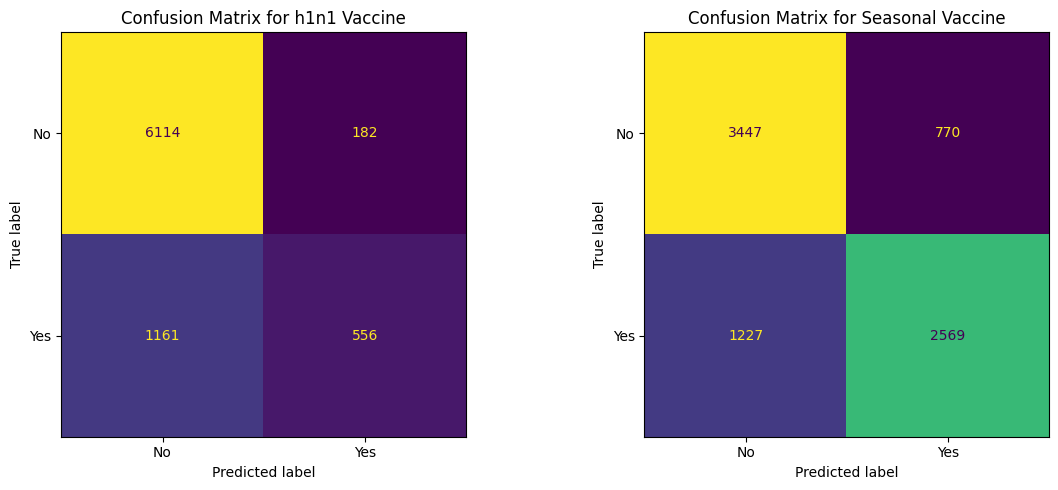

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix for h1n1 vaccine
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred[:, 0])
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['No', 'Yes'])
disp_h1n1.plot(ax=ax[0], colorbar=False)
ax[0].set_title('Confusion Matrix for h1n1 Vaccine')

# Confusion matrix for seasonal vaccine
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred[:, 1])
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['No', 'Yes'])
disp_seasonal.plot(ax=ax[1], colorbar=False)
ax[1].set_title('Confusion Matrix for Seasonal Vaccine')

plt.tight_layout()
plt.show()

The confusion matrix for h1n1_vaccine shows an astounding proportion of true negatives, which is a good sign since **the model is predicting 96% of negative cases correctly**. In contrast, the rate of false negatives is quite high, since more than 65% of the positive cases are being classified incorrectly. This rate of false negatives may be caused by the **inbalance and presence of noise** in the dataset.

Quite the same can be said about the confusion matrix for seasonal_vaccine, where the model is predicting most of negative cases correctly, but only a little more than the half of positive cases have been given a correct classification.

### ROC Graph

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

/home/miguelxd/.local/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


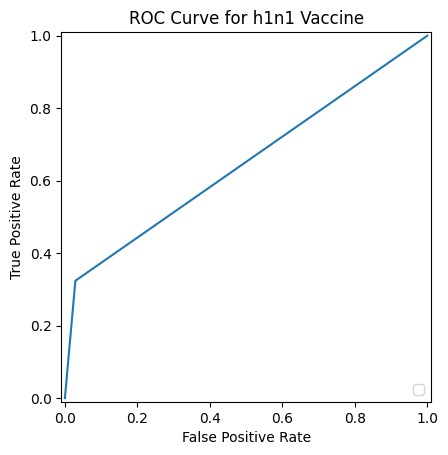

/home/miguelxd/.local/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


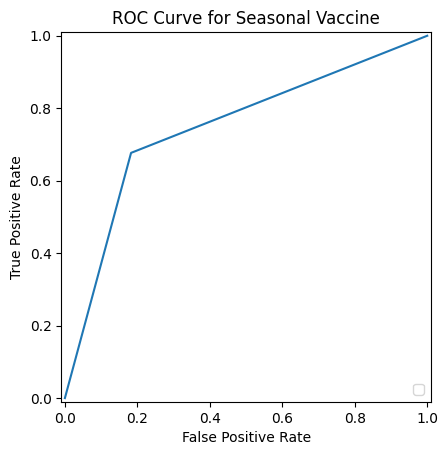

In [28]:
# Plot the ROC Graph
from sklearn.metrics import roc_curve, RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test['h1n1_vaccine'], y_pred[:, 0])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('ROC Curve for h1n1 Vaccine')
plt.show()

fpr, tpr, _ = roc_curve(y_test['seasonal_vaccine'], y_pred[:, 1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('ROC Curve for Seasonal Vaccine')
plt.show()

The ROC curves show a sharp increase at the beginning, which means that there are more true positives with a low false positive rate, but this quickly turns into a diagonal shape indicating that the classifier is not able to distinguish between the classes. From both curves, the one for seasonal_vaccine is slightly better than the one for h1n1_vaccine, but both are not good enough for the model to be considered as a good classifier.

### AUROC

As seen in the metric log, the AUROC tends to fall within the range between 0.65 and 0.7, which is quite high but not enough for making this model compete against others with higher performance. 

### F1-Score

The F1-score shown in the logs does not even exceed 0.6, giving a clear sign that the model is not predicting the classes in a desirable way. This is justified by the confusion matrix and the ROC curves, which show a disproportionate number of false positives.

## Conclusion

Regardless of the results obtained through the execution of this notebook, some other executions have been made in the past. The team recorded their results using MLflow. Here is a peek at the obtained results:

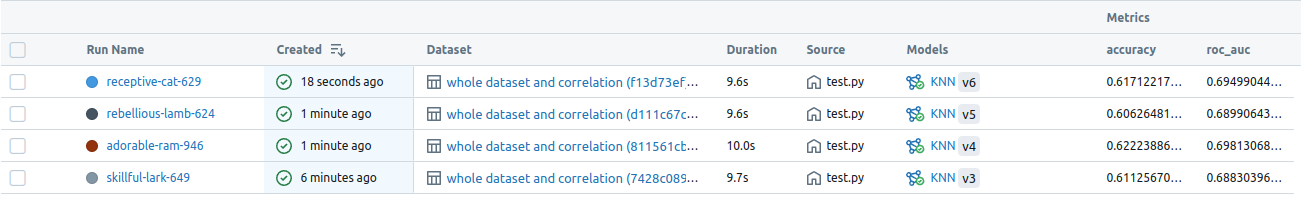

It is clear that the performance of this algorithm was very poor in relation to Random Forest. The team chose to try it out since in some cases it could give a very close performance to Random Forest. However, **the high presence of outliers** and the **imbalance of the dataset** take a toll on KNN's performance, whose strong dependency on the dataset (making it a strong part of the model's mathematical base) makes it sensitive to outliers and noise. This is a sign that models sensitive to outliers and noise are not the best choice for this dataset, and that maybe the dataset requires further preprocessing.